# Adagrad

在我们之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为$f$，自变量为一个二维向量$[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：

$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

在[“动量法”](./momentum.md)一节里我们看到当$x_1$和$x_2$的梯度值有较大差别时，我们需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。这一节我们介绍Adagrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题。


## 算法

Adagrad的算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，adagrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-6}$。这里开方、除法和乘法的运算都是按元素进行的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

## 特点

需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，Adagrad在迭代后期由于学习率过小，可能较难找到一个有用的解。

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察Adagrad对自变量的迭代轨迹。我们实现Adagrad并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使得学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1 -2.382563, x2 -0.158591


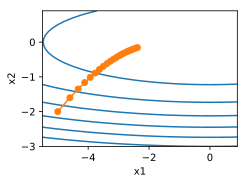

In [1]:
%matplotlib inline
import d2lzh as d2l
import math
from mxnet import nd

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

下面增大学习率到$2$。可以看到自变量更为迅速地逼近了最优解。

epoch 20, x1 -0.002295, x2 -0.000000


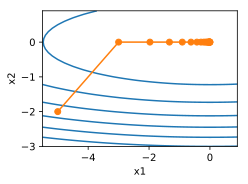

In [2]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 从零开始实现

同动量法一样，Adagrad需要对每个自变量维护同它一样形状的状态变量。我们根据算法中的公式实现Adagrad。

In [3]:
features, labels = d2l.get_data_ch7()

def init_adagrad_states():
    s_w = nd.zeros((features.shape[1], 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s[:] += p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

与[“小批量随机梯度下降”](minibatch-sgd.md)一节中的实验相比，我们在这里使用更大的学习率来训练模型。

loss: 0.242716, 0.261210 sec per epoch


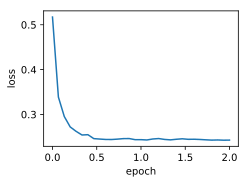

In [4]:
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

## 简洁实现

通过算法名称为“adagrad”的`Trainer`实例，我们便可使用Gluon实现的Adagrad算法来训练模型。

loss: 0.243189, 0.299661 sec per epoch


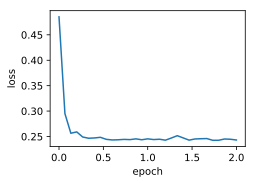

In [5]:
d2l.train_gluon_ch7('adagrad', {'learning_rate': 0.1}, features, labels)

## 小结

* Adagrad在迭代过程中不断调整学习率，并让目标函数自变量中每个元素都分别拥有自己的学习率。
* 使用Adagrad时，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。

## 练习

* 在介绍Adagrad的特点时，我们提到了它可能存在的问题。你能想到什么办法来应对这个问题？
* 在实验中尝试使用其他的初始学习率，结果有什么变化？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2273)

![](../img/qr_adagrad.svg)


## 参考文献

[1] Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive subgradient methods for online learning and stochastic optimization. Journal of Machine Learning Research, 12(Jul), 2121-2159.